# Intro to Chemical Dynamics: Plotting the Spin-Population Correlation Function

In [23]:
import numpy as np

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

import initializers as init

## Some helpful functions: 

In [25]:
def bath_hamiltonian(p, q, w):
    """
    returns the bath hamiltonian
    
    Input:
    1. p -- momenta of the oscillators
    2. q -- positions of the oscillators
    3. w -- frequency of the oscillators 
    
    Output:
    1. energy of the oscillators is given by: p^2/2m + m(wx)^2, a real number
    """
    return np.sum(p**2 + (w*q)**2)/2.0

In [26]:
def system_hamiltonian(delta, varepsilon):
    """
    returns the energy of the system: delta*s_x + varepsilon*s_z
    
    Input:
    1. delta       -- coupling energy of the two states
    2. varepsilon  -- energy bias
    
    Output:
    1. the system hamiltonian without coupling, a 2x2 matrix
    """
    
    
    return delta * sigma_x() + varepsilon * sigma_z()

In [27]:
def coupling_hamiltonian(q, c):
    """    
    Input:
    1. q  -- an array containing the positions of the oscillators
    2. c  -- an array containing the coupling constants
    
    Output:
    1. the coupling Hamiltonian; a real number
    """
    return np.dot(c, q)

In [28]:
def total_energy(wf, p, q, c, w, delta, varepsilon):
    
    """
    returns the total energy of the system + bath
    
    Input:
    1. wf         -- the wavefunction
    2. p          -- momenta of the oscillators
    3. q          -- positions of the oscillators
    4. c          -- coupling constants
    5. w          -- oscillator frequency
    6. delta      -- coupling energy for the two states
    7. varepsilon -- energy bias
    
    Output:
    1. energy -- Hb + Hs - s_z*H_c
    """
    
    hs = system_hamiltonian(delta, varepsilon)
    hb = bath_hamiltonian(p, q, w) * identity()
    hc_s_z = coupling_hamiltonian(q, c) * sigma_z()

    energy = expectation_value(wf, hb) + expectation_value(wf, hs) - expectation_value(wf, hc_s_z) 
    
    return energy

In [29]:
def system_force_on_bath(expwf, q, c):
    return expwf * np.sum(c)

In [30]:
def sigma_z():
    """
    returns the Pauli matrix, sigma_z, no inputs needed
    """
    return np.array([[1.0,0.0],
                     [0.0,-1.0]])

In [31]:
def sigma_x():
    """
    returns the Pauli matrix, sigma_x, no inputs needed
    """
    return np.array([[0.0,1.0],
                     [1.0,0.0]])

In [32]:
def identity():
    """
    returns the 2x2 identity matrix
    """
    return np.array([[1.0,0.0],
                     [0.0,1.0]])

In [33]:
def cw_rot(theta):
    """
    returns a clockwise rotation matrix evaluated at theta
    """
    return np.array([[np.cos(theta), np.sin(theta)],
                     [-np.sin(theta),np.cos(theta)]])

In [34]:
def expectation_value(f, A):
    """
    computes the expectation value of an operator
    
    Input:
    1. function, a vector 
    
    Output:
    1. f^T A f, the expecation value of A
    """
    f_adj = np.conj(f).T
    right_side = np.dot(f,A)
    expectation_value = np.dot(f_adj, right_side).real
    
    return expectation_value

In [35]:
def s_c_hamiltonian(q, c, delta, varepsilon):
    """
    returns the hamiltonian for the system and coupling
    """
    hc = coupling_hamiltonian(q,c)
    hs = system_hamiltonian(delta, varepsilon)
    return hs * identity() - hc * sigma_z()

In [36]:
def outer_product(f):
    
    f_adj = np.conj(f).T
    
    return np.dot(f, f_adj)

In [37]:
def expectation_value_red(rho, A):
    return np.trace(np.dot(rho, A))

In [38]:
def get_derivative_coupling(position, coupling, delta, varepsilon):
    """
    returns the vector element in row 1 column 2 of the derivative coupling matrix
    """
    
    denominator = (np.dot(position, coupling) + varepsilon)**2 + delta**2
    numerator = coupling * delta / 2
    
    return numerator / denominator

## Bath initialization

In [39]:
def initialize_wigner_bath(number_of_modes, w, beta):
    """  
    Input:
    1. number_of_modes    -- number of oscillators in the environment surrounding the system
    2. w                  -- frequency of each oscillator
    3. beta               -- inverse of thermal energy
    
    Output:
    1. momentum_coord -- an array containing the initialized momentum coordinates
    2. position_coord -- an array containing the initialized position coordinates
    """
    
    # creating the momentum and position coordinates, all initially set to zero
    p = np.zeros(number_of_modes, float)
    q = np.zeros(number_of_modes, float)
    
    for i in range(number_of_modes):
        u = beta * w[i] / 2
        tanhu = np.tanh(u)
        
        p[i] = np.random.normal(0.0, (w[i] / (2 * tanhu))**0.5)
        q[i] = np.random.normal(0.0, (1 / (2 * w[i] * tanhu))**0.5)
        
    return p, q

In [40]:
def initialize_classical_bath(number_of_modes, w, beta):
    """
       
    Input:
    1. number_of_modes    -- number of oscillators in the environment surrounding the system
    2. w                  -- frequency of each oscillator
    3. beta               -- inverse of thermal energy
    
    Output:
    1. momentum_coord -- an array containing the initialized momentum coordinates
    2. position_coord -- an array containing the initialized position coordinates
    """
    
    # creating the momentum and position coordinates, all initially set to zero
    p = np.zeros(number_of_modes, float)
    q = np.zeros(number_of_modes, float)
    
    for i in range(number_of_modes):
        p[i] = np.random.normal(0.0, (1 / beta)**0.5)
        q[i] = np.random.normal(0.0, (1 / (w[i]**2 * beta))**0.5)
        
    return p, q

## Bath integrator, followed by a system integrator

In [41]:
def bath_step(wf, p, q, c, w, dt):
    """
    Increment the momentum and position coordinates half a time-step forward using the
    integrators derived in section 2.5.4
       
    Input:
    1. wf         -- two component wf containing c+ and c- both as functions of time
    2. p          -- array containing the momenta of each oscillator
    3. q          -- array containing the positions of each oscillator
    4. c          -- coupling strength/coefficient of this mode
    5. w          -- frequency of this mode
    6. dt         -- timestep
    
    Output:
    1. p_new is an array containing the updated momentum coordinates
    2. q_new is an array containing the updated position coordinates
    """

    arg = w * dt/2
    exp_wf = expectation_value(wf,sigma_z())  # here's the error :)
    shift = q + c * exp_wf / w**2
    
    p_new = p * np.cos(arg) - shift * w * np.sin(arg)
    
    q_new = np.cos(arg) * shift + p * np.sin(arg) / w - c * exp_wf / w**2
    
    return p_new, q_new

In [42]:
def system_step(wf, q, c, delta, varepsilon, dt):
    """    
    Increment the expectation value of sigma_z one step forward using the position 
    integrator derived in section 2.5.4
       
    Input:
    1. wf                -- wavefunction containing the coefficients in a numpy array [c+1, c-1]
    2. q                 -- an array containing the positions of each oscillator
    3. c                 -- coupling constants of the oscillators
    4. delta             -- coupling energy of the two states
    5. varepsilon        -- energy bias
    6. dt                -- timestep
    
    Output:
    1. an array containing c_+1(t) and c_-1(t), in that order
    """
    # getting hc_prime and lambda
    hc_prime = -coupling_hamiltonian(q, c) + varepsilon
    lbda = (hc_prime**2 + delta**2)**0.5
    
    arg = lbda * dt
    a11 = np.cos(arg) - 1.0j * hc_prime * np.sin(arg) / lbda
    a12 = -1.0j * delta * np.sin(arg) / lbda
    a21 = a12
    a22 = np.conj(a11)
    
    # system integrator matrix
    exp_H = np.array([[a11, a12],
                      [a21, a22]])
    
    return np.dot(exp_H, wf)

## Split evolution method

In [43]:
def split_evolution(wf, p, q, c, w, delta, varepsilon, dt):
    """
    completes one iteration of the split-evolution method
       
    Input:
    1. wf           -- wf of the system as a two dimensional vector; components 1 and 2 are c+ and c-, resp.
    2. p            -- momenta of the oscillators
    3. q            -- positions of the oscillators
    3. c            -- coupling constant of each oscillator
    4. w            -- vibrational frequency of each oscillator
    5. delta        -- coupling energy of the two states
    6. varepsilon   -- energy bias
    7. dt           -- time step

    Output:
    1. wf_new           -- wavefunction components evolved through timestep dt
    2. p_final          -- momentum coordinates integrated through timestep dt
    3. q_final          -- position coordinates integrated through timestep dt
    """
    
    # increment the bath one half of a time step; do I have to initialize arrays?
    p_new, q_new = bath_step(wf, p, q, c, w, dt) 
    
    # increment the system by a full time step
    wf_new = system_step(wf, q_new, c, delta, varepsilon, dt)
    
    # increment the bath one half of a time step, so now the system and bath are at the same time
    p_final, q_final = bath_step(wf_new, p_new, q_new, c, w, dt)

    return wf_new, p_final, q_final

## Realization function

In [44]:
def realization(c, w, beta, delta, varepsilon, f, ub, dt, realization_type):
    """
    computes one set of trajectories
    """
    # create bath with gaussian distribution
    
    if (realization_type == wigner):
        momentum, position = init.initialize_wigner_bath(f, w, beta)
    else:
        momentum, position = init.initialize_classical_bath(f, w, beta)
        
    # initialize the wave function
    wf = np.array([1.0 + 0.0j, 0.0 + 0.0j])
    
    # spin is keeping track of sigma_z over time
    measurements = np.arange(0, ub, dt)
    spin = np.zeros(len(measurements), float)
    tsteps = len(measurements)
    
    system = np.zeros_like(spin) #
    bath = np.zeros_like(spin) #
    coupling = np.zeros_like(spin) #
    totalE = np.zeros_like(spin) #
    force = np.zeros_like(spin) #

    for i in range(tsteps):
        rho = outer_product(wf)
        
        #spin[i] = np.trace(np.dot(rho, sigma_z())).real
        
        spin[i] = expectation_value(wf, sigma_z()).real 
        
        sh = system_hamiltonian(delta, varepsilon) #
        
        #system[i] = np.trace(np.dot(rho, sh)).real
        
        system[i] = expectation_value(wf, sh) #
        bath[i] = bath_hamiltonian(momentum, position, frequency)
        coupling[i] = -coupling_hamiltonian(position, coupling_constants) * spin[i]
        totalE[i] = total_energy(wf, momentum, position, coupling_constants, frequency, delta, varepsilon)
        #totalE[i] = system[i] + bath[i] - coupling[i]
        force[i] = system_force_on_bath(spin[i], position, c)
        
        wf_n, p_n, q_n = split_evolution(wf, momentum, position, c, w, delta, varepsilon, dt)
    
        wf = wf_n
        momentum = p_n
        position = q_n
    
    return spin, system, bath, coupling, totalE, force

## Code parameters

In [45]:
# all parameters are defined in terms of delta, the coupling of the two states
delta = 1.0                      # electronic coupling of the two states
beta = 0.25 / delta              # inverse of thermal energy
omega_c = 1.0 * delta            # bath cut-off frequency
varepsilon = 0.0                 # energy bias
eta = delta * 0.1                # coupling strength between the system and the bath 
dt = 0.01                        # time step - 0.01
ub = 12.0                        # end time - 12
wigner = "wigner"
classical = "classical"

### Create arrays to hold the frequency of the $j^\text{th}$ oscillator as well as its corresponding coupling constant

In [46]:
# setting the number of oscillators in the system
number_of_modes = 200

# initialize an index array to help construct arrays to carry the coupling constants and frequencies
index_array = np.zeros(number_of_modes, float)    

# populating these arrays based on the Ohmic discretization methods in section 2.5.1
index_array = (np.arange(1,number_of_modes + 1, 1) - 0.5) / number_of_modes
frequency = -omega_c * np.log(index_array)                                     
coupling_constants = frequency * (2 * eta * omega_c / (number_of_modes * np.pi))**0.5   

In [24]:
# initialize spin, system, bath, coupling, total
w_spin, w_system, w_bath, w_coupling, w_total, w_force = realization(coupling_constants, 
                                                                  frequency, beta, 
                                                                  delta, varepsilon, 
                                                                  number_of_modes, 
                                                                  ub, dt, wigner)

c_spin, c_system, c_bath, c_coupling, c_total, c_force = realization(coupling_constants, 
                                                                      frequency, beta, 
                                                                      delta, varepsilon, 
                                                                      number_of_modes, 
                                                                      ub, dt, classical)

n = 49
for i in range(n):
    spin_nw, system_nw, bath_nw, coupling_nw, total_nw, force_nw = realization(coupling_constants, frequency, beta, 
                                                                       delta, varepsilon, number_of_modes, 
                                                                       ub, dt, wigner)
    
    spin_nc, system_nc, bath_nc, coupling_nc, total_nc, force_nc = realization(coupling_constants, frequency, beta, 
                                                                       delta, varepsilon, number_of_modes, 
                                                                       ub, dt, classical)
    w_spin += spin_nw
    w_system += system_nw
    w_bath += bath_nw
    w_coupling += coupling_nw
    w_total += total_nw
    w_force += force_nw
    
    c_spin += spin_nc
    c_system += system_nc
    c_bath += bath_nc
    c_coupling += coupling_nc
    c_total += total_nc
    c_force += force_nc

w_spin /= (n+1)
w_system /= (n+1)
w_bath /= (n+1)
w_coupling /= (n+1)
w_total /= (n+1)
w_force /= (n+1)

c_spin /= (n+1)
c_system /= (n+1)
c_bath /= (n+1)
c_coupling /= (n+1)
c_total /= (n+1)
c_force /= (n+1)

## Plot  $\langle \sigma_z(t)\rangle$

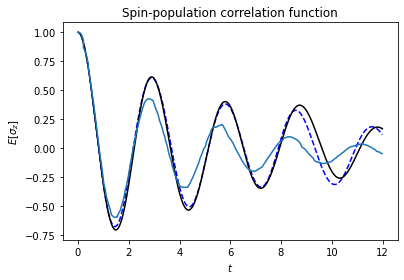

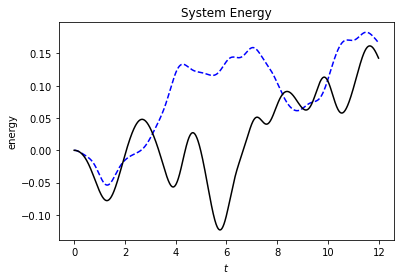

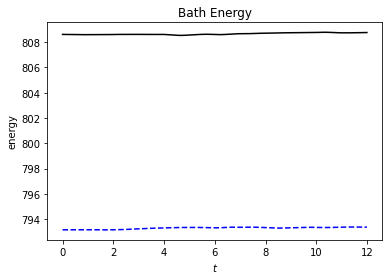

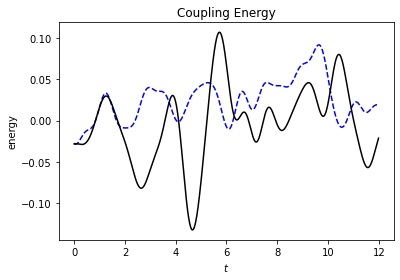

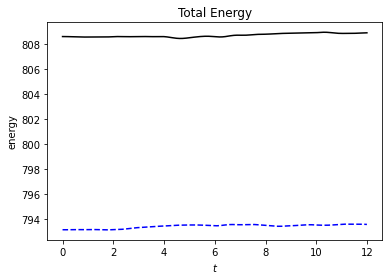

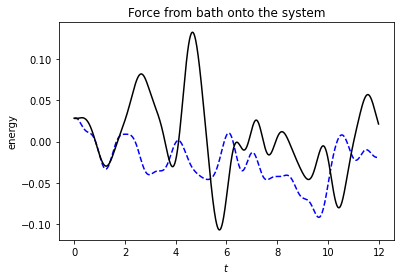

In [25]:
time = np.arange(0,ub,dt)
plt.plot(time, w_spin,"b--")
plt.plot(time, c_spin, "k-")
X, Y = np.loadtxt('spin_boson_model.txt', delimiter=',', unpack=True)
plt.plot(X, Y-(Y.max()-1))
plt.xlabel("$ t $")
plt.ylabel("$ E[\sigma_z ] $")
plt.title('Spin-population correlation function')
plt.show()

plt.title('System Energy')
plt.plot(time, w_system,"b--")
plt.plot(time, c_system, "k-")
plt.xlabel("$ t$")
plt.ylabel("energy")
plt.show()

plt.title('Bath Energy')
plt.plot(time, w_bath, "b--")
plt.plot(time, c_bath, "k-")
plt.xlabel("$ t $")
plt.ylabel("energy")
plt.show()

plt.title('Coupling Energy')
plt.plot(time, w_coupling, "b--")
plt.plot(time, c_coupling, "k-")
plt.xlabel("$ t$")
plt.ylabel("energy")
plt.show()

plt.title('Total Energy')
plt.plot(time, w_total, "b--")
plt.plot(time, c_total, "k-")
plt.xlabel("$ t $")
plt.ylabel("energy")
plt.show()

plt.title('Force from bath onto the system')
plt.plot(time, w_force, "b--")
plt.plot(time, c_force, "k-")
plt.xlabel("$ t $")
plt.ylabel("energy")
plt.show()

## Spectral Density Plots

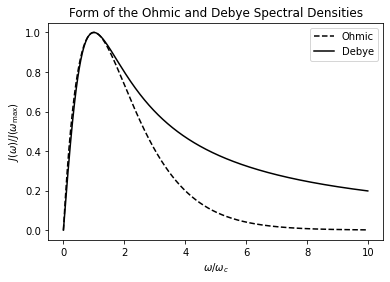

In [47]:
# define the spectral density functions
omega = np.arange(0, 10, dt)
ohmic = eta * omega * np.exp(-omega / omega_c)
debye = eta * omega_c * omega / (omega**2 + omega_c**2)

# construct the plot
plt.plot(omega / omega_c, ohmic / ohmic.max(), "k--")
plt.plot(omega / omega_c, debye / debye.max(), "k-")
plt.xlabel("$\omega/\omega_c$")
plt.ylabel("$J(\omega)/J(\omega_\mathrm{max})$")
plt.legend(['Ohmic', 'Debye'])
plt.title('Form of the Ohmic and Debye Spectral Densities')
plt.show()

# Old stuff

In [27]:
#np. seed?

In [28]:
"""initial = np.array([1.0, 0.0])
for i in range(12):
    c1 = initial[0] * np.cos(i) - (1.0j) * initial[1] * np.sin(i)
    c2 = initial[1] * np.cos(i) - (1.0j) * initial[0] * np.sin(i)
    initial = np.array([c1, c2])
    print(initial)
"""

a = np.array([1,2,3])
b = np.array([1,2,3])
print(np.dot(a,b))
    


14


## Create and initialize the system and the bath

## System evolution from initial state defined above

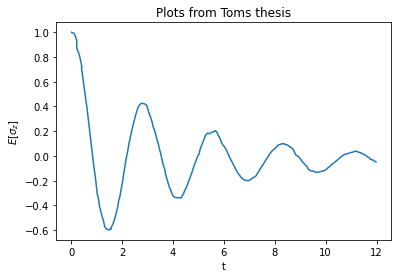

In [29]:
X, Y = np.loadtxt('spin_boson_model.txt', delimiter=',', unpack=True)
  
plt.plot(X, Y-(Y.max()-1))
plt.title('Plots from Toms thesis')
plt.xlabel('t')
plt.ylabel('$E[\sigma_z]$')
plt.show()